In [1]:
import matplotlib.pyplot as plt
from transform import transform
import os.path as path
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import time
import gc

warnings.filterwarnings("ignore")

%matplotlib inline
pd.options.display.float_format = '{:.5f}'.format
pd.options.display.max_columns = 100

train_columns = ['ip', 'app', 'os', 'channel', 'click_time', 'is_attributed']
dtypes = {
    'ip'            : 'uint32',
    'app'           : 'uint16',
    'os'            : 'uint16',
    'channel'       : 'uint16',
    'is_attributed' : 'uint8'
}

In [2]:
data_perc = 0.07 # ignorado se houver dados processados disponíveis
use_gpu = False

# carregando do csv

In [3]:
start = time.time()

has_processed_data = path.isfile('input/train_processed.csv')

filename = 'input/train_processed.csv' if has_processed_data else 'input/train.csv'
if has_processed_data:
    data_perc = 1.0

if filename=='input/train.csv':
    train_size_total = 184903890
else:
    train_size_total = sum(1 for line in open(filename))-1
train_size = int(data_perc*train_size_total)

data_train = pd.read_csv(filename, nrows=train_size, usecols=train_columns, parse_dates=['click_time'], dtype=dtypes)
print('{:.2f}s to load train data'.format(time.time()-start))

13.85s to load train data


# extraindo features interessantes

In [4]:
start = time.time()
transform(data_train)
process_time = time.time()-start
print('{:.2f}s to process data ({:.2f} lines/s)'.format(process_time, data_train.shape[0]/process_time))

# count-related features
## group by ['ip']
1.37s to generate feature ip_clicks
2.57s to generate feature ip_clicks_on_app
0.25s to generate feature ip_clicks_on_app_perc
## group by ['app']
0.92s to generate feature app_clicks
## group by ['os']
1.00s to generate feature os_clicks
## group by ['channel']
1.05s to generate feature channel_clicks
## group by ['ip', 'os']
2.37s to generate feature ip_os_clicks
4.81s to generate feature ip_os_clicks_on_app
0.12s to generate feature ip_os_clicks_on_app_perc
# time-related features
## group by ['ip']
31.05s to generate feature ip_duration
215.70s to generate feature ip_clicks_intervals_std
0.13s to generate feature ip_clicks_frequency
424.06s to generate feature ip_duration_on_app
445.92s to generate feature ip_clicks_on_app_intervals_std
0.16s to generate feature ip_duration_on_app_perc
0.13s to generate feature ip_clicks_on_app_frequency
# attributed perc-related features
## group by ['app']
4.56s to generate feature app_attributed_perc
#

# valores médios de cada feature

### clicks seguidos de download

In [5]:
data_train[data_train['is_attributed']==1].describe().drop(columns=['is_attributed'])[1:3]

,app,os,channel,click_time,ip_clicks,ip_clicks_on_app,ip_clicks_on_app_perc,ip_os_clicks,ip_os_clicks_on_app,ip_os_clicks_on_app_perc,ip_duration,ip_clicks_intervals_std,ip_clicks_frequency,ip_duration_on_app,ip_clicks_on_app_intervals_std,ip_duration_on_app_perc,ip_clicks_on_app_frequency,app_attributed_perc,os_attributed_perc,channel_attributed_perc
mean,32.06574,21.22603,205.75357,13.23869,1160.09959,24.32577,0.28538,136.63611,4.61505,0.53495,21200.54849,1091.25161,0.22783,6447.13914,1546.76206,0.44155,0.59499,0.28782,0.04071,0.16846
std,35.93043,41.62872,116.68224,9.44471,5443.50879,252.91405,0.40483,933.16651,45.20831,0.45350,14296.25902,1666.89193,0.48059,11575.72430,2037.47355,0.46360,0.54016,0.31916,0.06709,0.18075


### clicks não seguidos de downloads

In [6]:
data_train[data_train['is_attributed']==0].describe().drop(columns=['is_attributed'])[1:3]

,app,os,channel,click_time,ip_clicks,ip_clicks_on_app,ip_clicks_on_app_perc,ip_os_clicks,ip_os_clicks_on_app,ip_os_clicks_on_app_perc,ip_duration,ip_clicks_intervals_std,ip_clicks_frequency,ip_duration_on_app,ip_clicks_on_app_intervals_std,ip_duration_on_app_perc,ip_clicks_on_app_frequency,app_attributed_perc,os_attributed_perc,channel_attributed_perc
mean,12.64763,24.46659,254.47546,14.00423,2674.76174,308.14275,0.11792,362.00170,47.82454,0.20098,31452.90896,479.15790,0.08497,27376.51410,1982.69980,0.86297,0.03691,0.00142,0.00191,0.00166
std,16.38259,61.16834,129.21103,9.07251,7802.61161,1112.85495,0.11073,1400.52162,201.94704,0.21233,3820.69606,690.24363,0.25034,9038.66351,2202.70168,0.26678,0.17519,0.01426,0.00807,0.01453


# distribuições das variáveis

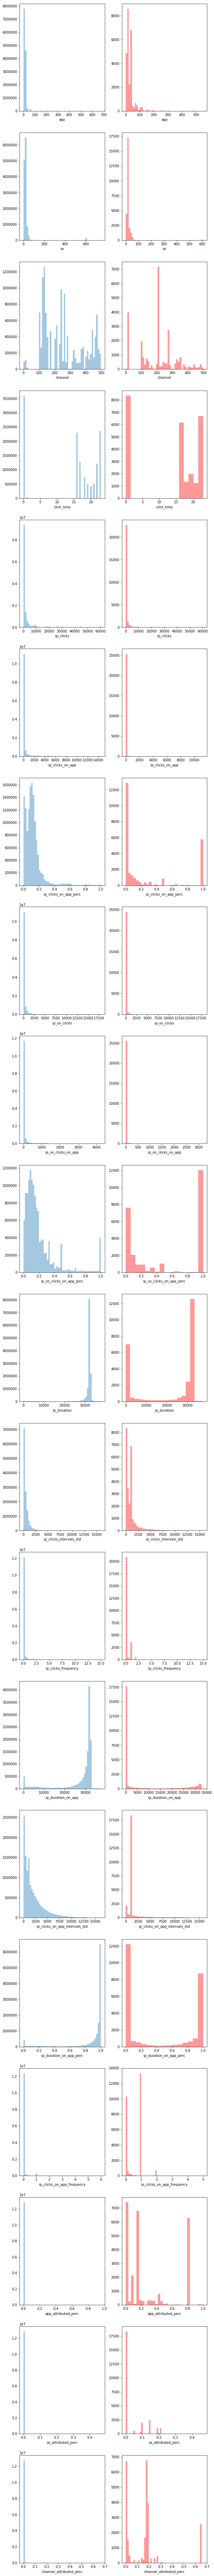

In [7]:
fig = plt.figure(figsize=(10,7*len(data_train.columns)))
count = 1
for column in data_train.columns:
    if column=='is_attributed':
        continue
    fig.add_subplot(data_train.shape[1], 2, count)
    sns.distplot(data_train[data_train['is_attributed']==0][column], kde=False)
    count += 1
    fig.add_subplot(data_train.shape[1], 2, count)
    sns.distplot(data_train[data_train['is_attributed']==1][column], kde=False, color='red')
    count += 1

# treinamento

In [8]:
from sklearn.model_selection import train_test_split
import xgboost as xgb

X = data_train.drop(columns=['is_attributed'])
y = data_train['is_attributed']

In [9]:
start = time.time()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
del X, y
gc.collect()
print('{:.2f}s to split data in train/test'.format(time.time()-start))

14.51s to split data in train/test


In [10]:
start = time.time()
unbalance_factor = data_train[data_train['is_attributed']==0].shape[0]/data_train[data_train['is_attributed']==1].shape[0]
del data_train
gc.collect()
print('{:.2f}s to compute unbalance factor: {}'.format(time.time()-start, unbalance_factor))

29.19s to compute unbalance factor: 501.92477463475285


In [11]:
# https://github.com/dmlc/xgboost/blob/master/doc/parameter.md
xgb_params = {
    'eta': 0.1,
    'max_leaves': 1024,
    'subsample': 0.8,
    'colsample_bytree': 0.7,
    'colsample_bylevel':0.7,
    'min_child_weight':0,
    'alpha': 5,
    'scale_pos_weight': unbalance_factor,
    'eval_metric': 'auc',
    'random_state': int(time.time()),
    'nthread': 4,
    'silent': True,
    'max_depth': 0,
    'grow_policy': 'lossguide',
    'tree_method': 'hist',
    'predictor': 'cpu_predictor',
    'objective': 'binary:logistic'
}

if use_gpu:
    xgb_params.update({'tree_method':'gpu_hist', 'predictor':'gpu_predictor', 'objective':'gpu:binary:logistic'})

In [12]:
start = time.time()
dtrain = xgb.DMatrix(X_train, y_train)
dvalid = xgb.DMatrix(X_test, y_test)
del X_train, y_train, X_test, y_test
gc.collect()
print('{:.2f}s to create xgboost data structures'.format(time.time()-start))

71.69s to create xgboost data structures


In [13]:
# watch accuracy in training and validation
watchlist = [(dtrain, 'training'), (dvalid, 'validation')]

start = time.time()
model = xgb.train(xgb_params, dtrain, 400, watchlist, maximize=True, early_stopping_rounds = 25, verbose_eval=5)
del dvalid, dtrain
gc.collect()
print('{:.2f}s to perform training'.format(time.time()-start))

[0]	training-auc:0.973112	validation-auc:0.928362
Multiple eval metrics have been passed: 'validation-auc' will be used for early stopping.

Will train until validation-auc hasn't improved in 25 rounds.
[5]	training-auc:0.989904	validation-auc:0.956504
[10]	training-auc:0.993359	validation-auc:0.960065
[15]	training-auc:0.995186	validation-auc:0.962632
[20]	training-auc:0.996261	validation-auc:0.963094
[25]	training-auc:0.996892	validation-auc:0.963399
[30]	training-auc:0.997309	validation-auc:0.964996
[35]	training-auc:0.997643	validation-auc:0.965522
[40]	training-auc:0.997947	validation-auc:0.966168
[45]	training-auc:0.998188	validation-auc:0.96649
[50]	training-auc:0.998398	validation-auc:0.966156
[55]	training-auc:0.998578	validation-auc:0.96602
[60]	training-auc:0.998721	validation-auc:0.966288
[65]	training-auc:0.998832	validation-auc:0.966279
Stopping. Best iteration:
[43]	training-auc:0.998095	validation-auc:0.966614

334.21s to perform training


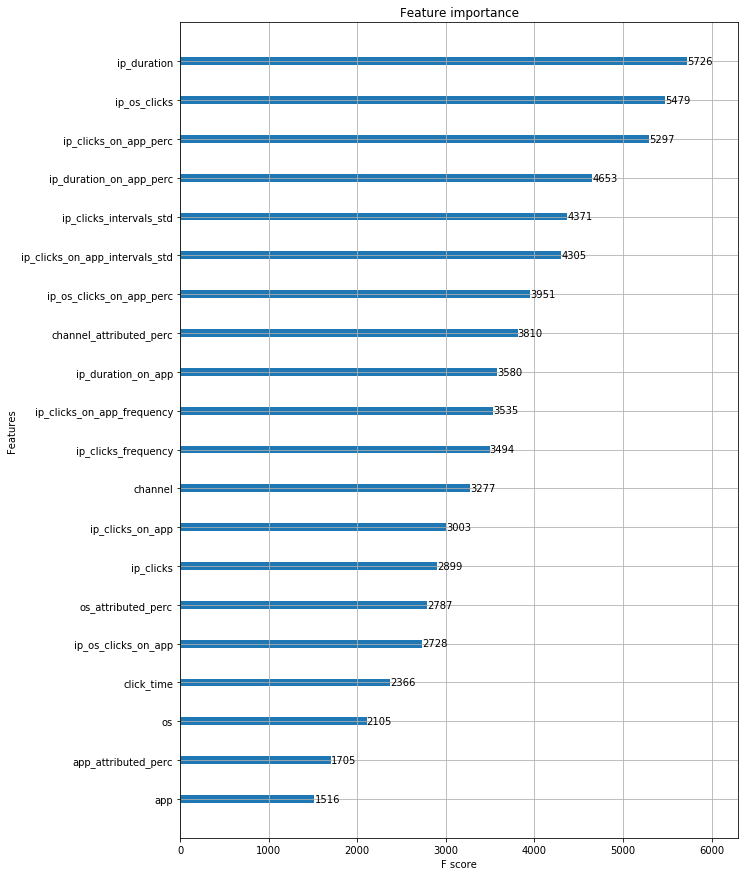

In [14]:
_, ax = plt.subplots(figsize=(10,15))
xgb.plot_importance(model, ax=ax)